In [52]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Single population model

#Each timestep, following processes are simulated in a given sequence
#1. Mortality of adults due to selection- Prob of death= (exp((T-T(opt))^2)/sigma)
#2. Reproduction-Mating between different genotypes represented by Barton's hypergeometric model
#3. Settlement- density dependent removal of newly produced larvae 

#Quantitative genetic model: 
#the 'heat tolerence' trait is determined by a total of L bialleilic loci, where allele "0" means
#unfavorable trait for temp. tolerence. All loci contribute independently (no linkage) and 
#equally. Therefore, the trait value of an individual is simply assumed to be the sum of all "1"
#alleles present in an individual. Approx. hypergeometric model for diploids is used 
#to describe the effect of evolutionary processes on trait propagation (barton 1992).

#Reproduction: a)Mating: A fraction of the population is assumed to reproduce asexually. The 
#rest of the population is assumed to start the mating process simultaneously where they 
#release their gametes in a pool and random mating is assumed to occur.

#Model parameters

#no. of loci
n=114
geno= collect(1:(2*n+1))
nt=length(geno)
#Growth rate
r=1.38
#Carrying capacity
K=1000
#Proportion of asexually reproducing individuals
pa=0.6

#Precalculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
#value' i an j are combined

G=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
            m=collect(0:min(j,k,i+j-k))
            G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
end
    
for k in 0:n
    G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
    for i1 in 0:n
        G[i1+1,i1+1,k+1] /= 2
    end
end
    
ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
         ind_haplR[1+i,1+k] = G[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
     R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                         ind_haplR[1+j,1+q .- (0:q)])
end
    

#Start the simulation
    
res=zeros(78,nt)    
    
N=rand(Uniform(0,1.0),nt)
Ng0= N ./ sum(N)
Np0= 950 .* Ng0 

    
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)

res[1,:]=Np    
 
#Some token trend of changes in optimal trait with time.    
topts=collect(range(100,stop=135,length=77))
    
for t in 1:77
                
        topt=topts[t]
        
        #Selection event
            
            probsurv=exp.(-((topt .-geno) .^2) ./ 500)
            #probsurv=1
            Np=Np.*probsurv
            
        #Reproduction event
        
        if(pa<1)
            
            newgen=zeros(Float64,nt)        
        
            probs=Ngen*Ngen'

            for i in 1:length(Ngen)

                newgen[i]=sum(probs.*R[:,:,i])
            end

            Np=((pa*sum(Np)) .* Ngen) + (((1-pa)*sum(Np)) .* newgen)

            Ngen=Np/sum(Np)
            
        end
        
        #Settlement
        
        Np=(sum(Np)+ (r*sum(Np)*(1-(sum(Np)/K)))) .* Ngen 
        
        Ngen=Np ./sum(Np)
        
        res[t+1,:]=Np

end 
    
    

[ Info: Saved animation to C:\Users\mihir\tmp.gif


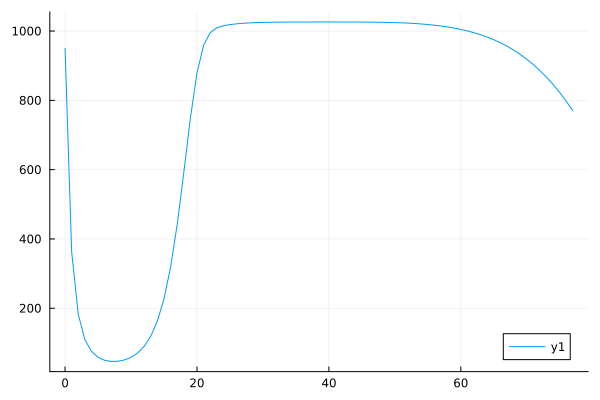

In [55]:
#Look at two results:
#1. How the population size changes over time
#2. How the trait distribution changes over time.

xs=collect(1:nt)

anim=@animate for i ∈ 1:78
    Plots.plot(xs, res[i,:])
end
gif(anim,fps=5)

x1=collect(0:77)
Plots.plot(x1,sum(eachcol(res)))

In [ ]:
#Spatially explicit version of the model

#Model parameters
#Define the parameters (except for genetic information) for each of the subpopulation

#no. of loci
n=114
geno= collect(1:(2*n+1))
nt=length(geno)

#No. subpopulations
npops=10

#Growth rate
r=repeat([1.38],npops)

#Carrying capacity
K=repeat([1000],npops)

#Proportion of asexually reproducing individuals
pa=0.6

#Migration matrix NpopsXNpops: Indicates the proportion of the population migrating
#from pop i to pop j
mmat=ones(Float64,npops,npops)
#The matrix can be customised with empirical data
#For now, let us assume that the matrix has identical Aij (i not equal to j)values and 
#total of 10% of the each population emigrates.
mmat=mmat/((npops-1)*10)
[mmat[x,x]=0 for x in 1:3]


#Precalculate the probabilities of getting an offspring with trait k when the gametes with 'trait 
#value' i an j are combined

G=zeros(Float64,n+1,n+1,n+1)

for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
            m=collect(0:min(j,k,i+j-k))
            G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
end
    
for k in 0:n
    G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
    for i1 in 0:n
        G[i1+1,i1+1,k+1] /= 2
    end
end
    
ind_haplR=zeros(Float64,2*n+1, 2*n+1)

for k in 0:n
    for i in 0:n
         ind_haplR[1+i,1+k] = G[1+i,1,1+k]
        for j in 0:n
            ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
        end
    end
end

R=zeros(Float64,nt,nt,nt)

for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
     R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .* 
                         ind_haplR[1+j,1+q .- (0:q)])
end
    

#Start the simulation
    
res=zeros(78,npops,nt)    
    
N=rand(Uniform(0,1.0),npops,nt)
Ng0= N ./ sum(eachcol(N))
Np0= 950 .* Ng0 
    
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)

res[1,:,:]=Np    
 
#Some token trend of changes in optimal trait with time.    
topts=collect(range(100,stop=135,length=77))
    
for t in 1:77
                
        topt=topts[t]
        
        #Selection event
            
            probsurv=exp.(-((topt .-geno) .^2) ./ 500)
            Np=Np .* probsurv'
            
        #Reproduction event
        
        if(pa<1)
            
            newgen=zeros(Float64,npops,nt)
            
            for i in 1:size(Ngen)[1]
                
                probs=Ngen[i,:]*(Ngen[i,:]')
                
                for j in 1:size(Ngen)[2]
                    
                    newgen[i,j]=sum(probs.*R[:,:,i])
                end
                
                Np[i,:]=((pa*sum(Np[i,:])) .* Ngen[i,:]) + (((1-pa)*sum(Np[i,:])) .* newgen[i,:])
                
                Ngen[i,:]=Np[i,:]/sum(Np[i,:])
                
            end
        
        #Settlement
            
        for i in 1:size(Np)[1]
                
            Np[i,:]=(sum(Np[i,:])+ (r[i]*sum(Np[i,:])*(1-(sum(Np[i,:])/K[i])))) .* Ngen[i,:] 
        
            Ngen[i,:]=Np[i,:] ./sum(Np[i,:])

            res[t+1,:,:]=Np
        end
            
        #Migration
        
end
        



In [84]:
N=rand(Uniform(0,1.0),npops,nt)

Ng0=N ./sum(eachcol(N))

10×229 Matrix{Float64}:
 0.00779167   0.0023624   0.00446725   0.00280964  …  0.00713848   0.00492584
 0.00679866   0.00372276  0.00595973   0.00285863     0.00201995   0.0047105
 0.0047023    0.00802471  0.00675077   0.00596216     0.00359998   0.00791661
 0.0071712    0.00569051  0.00498354   0.00349298     0.00454524   0.00171052
 0.00398187   0.00716546  0.0034353    0.00825781     0.00565302   0.00291655
 0.00625102   0.00202288  0.00525952   0.00810403  …  0.00116564   0.00815652
 0.00535274   0.00686365  0.000832281  0.00288689     0.00211117   0.00575617
 0.00819421   0.00342306  0.00151961   0.00106012     0.000800594  0.00635026
 0.00596114   0.00860783  0.00374407   0.00176719     0.00729929   0.00263198
 0.000740427  0.00738364  0.00447079   0.00559216     0.00700946   0.00282897

In [91]:
probsurv=exp.(-((topts[1] .-geno) .^2) ./ 500)

229-element Vector{Float64}:
 3.068736265489405e-9
 4.55063069183236e-9
 6.721194131889258e-9
 9.88744565699232e-9
 1.4487204867720514e-8
 2.114208992980118e-8
 3.073081315126579e-8
 4.449006193583829e-8
 6.415267805440613e-8
 9.213600834566135e-8
 1.3179739234671736e-7
 1.877790183105105e-7
 2.664711111911444e-7
 ⋮
 8.049469663281738e-13
 5.010853244716456e-13
 3.1068402375434455e-13
 1.9186200600672365e-13
 1.180108294094146e-13
 7.229654889580203e-14
 4.411396481999411e-14
 2.6810038677818034e-14
 1.62286207258361e-14
 9.78427392184295e-15
 5.875413231954853e-15
 3.5140752184873113e-15

175.15997037923253

In [126]:
res=zeros(78,npops,nt)    
    
N=rand(Uniform(0,1.0),npops,nt)
Ng0= N ./ sum(eachcol(N))
Np0= 950 .* Ng0 
    
Ngen=deepcopy(Ng0)
Np=deepcopy(Np0)

Np
    

10×229 Matrix{Float64}:
 1.56669  5.55397   2.39404  1.88436   …  3.96584   6.4664   1.5009
 7.84033  4.26367   4.44067  0.403098     1.84421   1.21864  6.7648
 6.47674  0.1819    2.65519  1.20538      7.10772   7.1409   5.38057
 4.52192  1.47635   1.86827  3.14125      1.62412   4.21606  5.75507
 5.58229  6.9131    4.70993  0.480533     6.44498   1.87754  1.15021
 2.57328  6.52486   1.01193  5.87561   …  0.562727  6.21329  2.30393
 2.63198  6.61939   8.25178  3.92292      2.86606   2.77116  5.05925
 4.14852  8.23388   1.68762  1.66271      6.41433   6.33507  7.24609
 4.38516  0.686599  4.68106  4.26465      7.2686    5.83734  4.26492
 5.47726  6.14404   4.43065  2.12829      6.16581   1.38811  5.38041